In [152]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import mutual_info_score, mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
data = pd.read_csv('data.csv', delimiter=';')
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,16,U,LE3,T,4,3,teacher,services,...,5,4,3,1,2,1,2,16,15,15
1,GP,M,18,U,LE3,T,1,1,other,other,...,2,3,5,2,5,4,0,6,5,0
2,GP,M,17,R,LE3,A,4,4,teacher,other,...,3,3,3,2,3,4,2,10,11,12
3,GP,F,15,U,LE3,T,3,2,services,other,...,4,4,4,1,1,5,10,7,6,6
4,GP,M,16,U,GT3,T,2,3,other,other,...,5,3,3,1,1,3,0,13,14,14


In [3]:
X = data.drop('G3', axis =1)
y = data['G3']


In [148]:
#manually binarize bc the column transformer doesn't like label binarizer 
lb = LabelBinarizer()
for x in  ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid','activities','nursery','internet','higher','romantic']:
    X[x] = lb.fit_transform(X[x])

In [149]:
X.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Dalc,Walc,health,absences,G1,G2,Pedu,Talc,Gavg,social
0,0,0,16,1,1,1,4,3,teacher,services,...,1,2,1,2,16,15,3.5,1.5,15.5,8
1,0,1,18,1,1,1,1,1,other,other,...,2,5,4,0,6,5,1.0,3.5,5.5,8
2,0,1,17,0,1,0,4,4,teacher,other,...,2,3,4,2,10,11,4.0,2.5,10.5,6
3,0,0,15,1,1,1,3,2,services,other,...,1,1,5,10,7,6,2.5,1.0,6.5,8
4,0,1,16,1,0,1,2,3,other,other,...,1,1,3,0,13,14,2.5,1.0,13.5,8


In [5]:
#engineered features: 
X["Pedu"] = (X['Medu'] + X['Fedu'])/2 #parent education avg
X['Talc'] = (X['Dalc'] + X['Walc'])/2 #total alc consumption 
X["Gavg"] = (X['G1'] + X['G2'])/2 #avg g1 and g2 grade
X['social'] = X['goout'] + X['romantic'] + X['famrel'] #sum of goout and romantic and famrel, max value of 11

In [161]:
#OHE, will happen after test/train/split
ohe = OneHotEncoder()
col_trans = ColumnTransformer([('onehot', ohe, ['Mjob', 'Fjob', 'reason', 'guardian'])],
                                    remainder = 'passthrough')
test = pd.DataFrame(col_trans.fit_transform(X), columns = [s.split('__')[1] for s in col_trans.get_feature_names_out()])
test.head()

,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,...,Dalc,Walc,health,absences,G1,G2,Pedu,Talc,Gavg,social
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,2.0,1.0,2.0,16.0,15.0,3.5,1.5,15.5,8.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,2.0,5.0,4.0,0.0,6.0,5.0,1.0,3.5,5.5,8.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,2.0,3.0,4.0,2.0,10.0,11.0,4.0,2.5,10.5,6.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,5.0,10.0,7.0,6.0,2.5,1.0,6.5,8.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,3.0,0.0,13.0,14.0,2.5,1.0,13.5,8.0


In [162]:
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 1)
#Encode and scale
X_train = pd.DataFrame(col_trans.fit_transform(X_train), columns = [s.split('__')[1] for s in col_trans.get_feature_names_out()])
X_test = pd.DataFrame(col_trans.fit_transform(X_test), columns = [s.split('__')[1] for s in col_trans.get_feature_names_out()])


In [157]:
# finding best feature selection for a given model
def test_features(model, selectors): 
    stats = pd.DataFrame(columns = ['selector', 'features', 'r2', 'mse', 'mae', 'relative error'])
    for selector in selectors:
        selector.fit(X_train, y_train)
        features = list(selector.get_feature_names_out())
        train_temp = X_train[features]
        test_temp = X_test[features]
        model.fit(train_temp, y_train)
        pred = model.predict(test_temp)
        r2 = r2_score(y_test, pred)
        mse = mean_squared_error(y_test, pred)
        #a proxy for percent error- need to fix
        mae = mean_absolute_error(y_test, pred)
        relative_e = mae/y_test.mean()
        stats.loc[len(stats.index)]= [str(selector), features, r2, mse, mae, relative_e]
    return(stats)


In [46]:
#get the best feature combination for each model type 
def compare_models(models, metric):
    stats = pd.DataFrame(columns = ['model', 'k features', 'features', 'r2', 'mse', 'mae', 'relative error'])
    for m in models:
        temp = test_features(m, selectors)
        if metric == 'r2': 
            best = [str(m)] + temp[temp[metric] == temp[metric].max()].values.tolist()[0]
        else: 
            best = [str(m)] + temp[temp[metric] == temp[metric].min()].values.tolist()[0]
        best[1] = len(best[2])
        stats.loc[len(stats.index)] = best
    stats = stats.sort_values(by = metric).reset_index(drop=True)
    return stats 


In [10]:
#tune model
def tune_model(model, x, params):
    tuner = GridSearchCV(estimator=model, param_grid = params, scoring= 'neg_mean_absolute_error')
    tuner.fit(x,y_train)
    return pd.DataFrame(tuner.cv_results_).sort_values(by='rank_test_score')[['params', 'mean_test_score']]

In [11]:
#models and selectors 
models = [SVR(), SGDRegressor(), RandomForestRegressor(), Ridge(), KNeighborsRegressor(), GradientBoostingRegressor()]
selectors = [SelectKBest(k = i, score_func = mutual_info_regression) for i in range (3, len(X_train.columns)+1)]

In [163]:
rf_features = test_features(RandomForestRegressor(), selectors)

In [164]:
rf_features['n'] = [len(l) for l in rf_features['features']]

In [165]:
rf_features.head()

,selector,features,r2,mse,mae,relative error,n
0,"SelectKBest(k=3, score_func=<function mutual_i...","[G1, G2, Gavg]",0.724882,5.852622,1.489020,0.134082,3
1,"SelectKBest(k=4, score_func=<function mutual_i...","[absences, G1, G2, Gavg]",0.790044,4.466423,1.103026,0.099325,4
2,"SelectKBest(k=5, score_func=<function mutual_i...","[Medu, absences, G1, G2, Gavg]",0.816719,3.898963,1.079841,0.097237,5
3,"SelectKBest(k=6, score_func=<function mutual_i...","[Walc, absences, G1, G2, Talc, Gavg]",0.799675,4.261548,1.090540,0.098200,6
4,"SelectKBest(k=7, score_func=<function mutual_i...","[failures, higher, romantic, absences, G1, G2,...",0.805212,4.143746,1.098231,0.098893,7


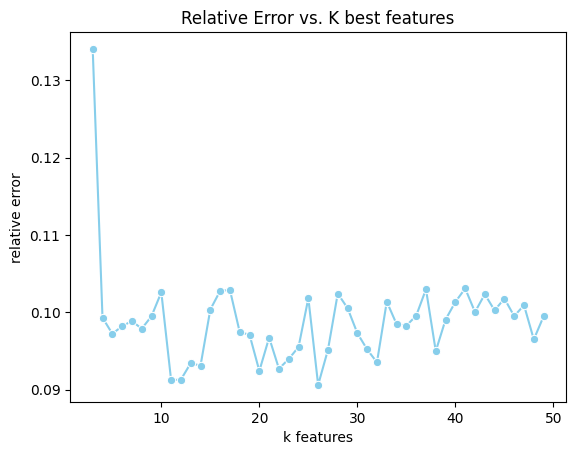

In [189]:

sns.lineplot(x=rf_features['n'], y=rf_features['relative error'], marker='o', color = 'skyblue')
plt.xlabel ('k features')
plt.title('Relative Error vs. K best features')
plt.savefig('figures/kfeatures.png', dpi = 300, bbox_inches='tight')

In [176]:
#hyperparameters to test
params = {"SVR()": {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], #SVR
          'gamma' : [10**x/10000 for x in range (3)],
          'C' : [10**x/100 for x in range (0,3)]},
          "SGDRegressor()": {'loss' : ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],   #SGD
           'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']   
          },
          "RandomForestRegressor()": {'n_estimators' : range(10, 160, 10),     #Random Forest
           'max_features' : ['sqrt', 'log2', None]
          },
          "Ridge()": {'alpha' : [10**x/100000 for x in range(0, 10,2)]  #Ridge
          },
          "KNeighborsRegressor()": {'n_neighbors' : range(2,21),     #KNeighbors
           'weights'  : ['uniform', 'distance']     
          },
          "GradientBoostingRegressor()": {
            'loss' : ['squared_error', 'absolute_error', 'huber', 'quantile'],  #Gradient Boosting
            'n_estimators' : range(10, 160, 10)
          }
}

In [168]:
best_features = compare_models(models, 'relative error')


In [30]:
best_features.head(6)

,model,k features,features,r2,mse,mae,relative error
0,RandomForestRegressor(),10,"[address, Medu, schoolsup, activities, higher,...",0.863548,2.902771,0.984632,0.088664
1,GradientBoostingRegressor(),14,"[Mjob_at_home, address, Medu, studytime, failu...",0.840781,3.387085,1.037914,0.093461
2,KNeighborsRegressor(),8,"[address, Pstatus, failures, absences, G1, G2,...",0.879977,2.553263,1.056842,0.095166
3,SGDRegressor(),3,"[G1, G2, Gavg]",0.808091,4.082496,1.188968,0.107063
4,SVR(),4,"[absences, G1, G2, Gavg]",0.802836,4.194288,1.205322,0.108536
5,Ridge(),3,"[G1, G2, Gavg]",0.814098,3.954726,1.209510,0.108913


In [169]:
best_features['summary'] = [f"{best_features.iloc[i]['model']}\n{best_features.iloc[i]['k features']} features" for i in best_features.index]

/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_19544/3429856834.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = best_features['summary'], x= best_features['relative error'], palette = sns.color_palette("husl", 6))


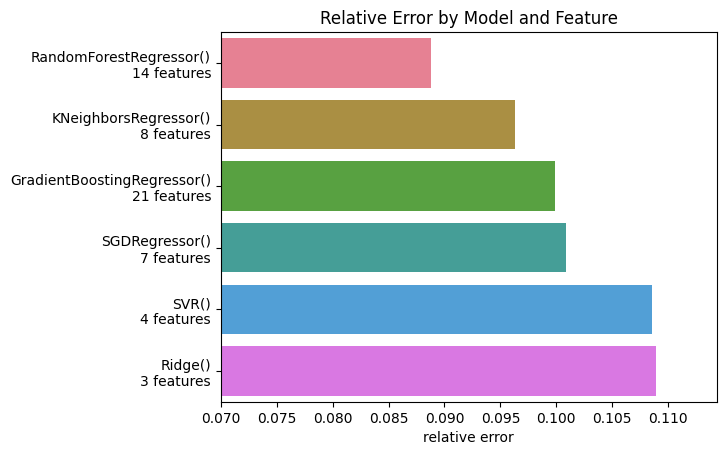

In [188]:
sns.barplot(y = best_features['summary'], x= best_features['relative error'], palette = sns.color_palette("husl", 6))
plt.xlim(0.07)
plt.ylabel('')
plt.title("Relative Error by Model and Feature")
plt.savefig('figures/relative_e_feature_selection.png', dpi = 300, bbox_inches='tight')

/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_19544/3497645649.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = best_features['summary'], x= best_features['r2'], palette = sns.color_palette("husl", 6))


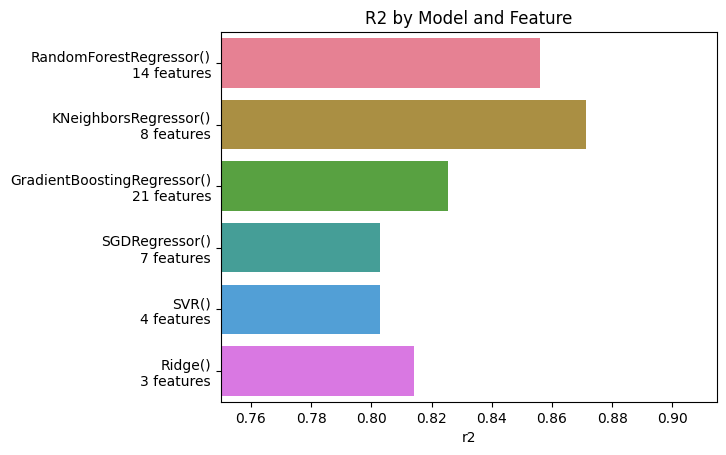

In [186]:
sns.barplot(y = best_features['summary'], x= best_features['r2'], palette = sns.color_palette("husl", 6))
plt.xlim(0.75)
plt.ylabel('')
plt.title("R2 by Model and Feature")
plt.savefig('figures/r2_feature_selection.png', dpi = 300, bbox_inches='tight')

In [177]:
#tune hyperparameters for the top 3 models
stats = {}
for i in (best_features.index[:3]): 
    model = eval(best_features.iloc[i]['model'])
    features = best_features.iloc[i]['features']
    hps = params[best_features.iloc[i]['model']]
    results = tune_model(model, X_train[features], hps)
    print(f"doing {model}")
    stats[(str(model), str(features))] = results

doing RandomForestRegressor()
doing KNeighborsRegressor()
doing GradientBoostingRegressor()


In [111]:
#get parameters into individual columns so i can do visualizations. extremely inefficient lol 
fig, ax = plt.subplots(1,3, figsize =(20,20))
for k, v in stats.items():
    v[['param1', 'param2']] = v['params'].apply(pd.Series)
    v = v.rename(columns= {'param1' : list(v.iloc[0]['params'].keys())[0], 'param2' : list(v.iloc[0]['params'].keys())[1]})
    v = v.iloc[:,:-2]
    temp = v.drop('params', axis = 1)
    temp.pivot(index = temp.columns[-1], columns = temp.columns[-2], values = 'mean_test_score')
    sns.heatmap(temp, ax = ax[0])



ValueError: could not convert string to float: 'log2'

Error in callback <function flush_figures at 0x148767060> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [178]:
#apply tuned hyperparameters 
tuned_stats = pd.DataFrame(columns = ['model', 'params','n','features', 'r2', 'mse', 'mae', 'relative error'])
for k,v in stats.items():
    params = v['params'][0]
    features = eval(k[1])
    model = eval(k[0][:-2])(**params)
    model.fit(X_train[features], y_train)
    pred = model.predict(X_test[features])
    r2 = r2_score(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    percent_e = mae/y_test.mean()
    tuned_stats.loc[len(tuned_stats.index)] = [k[0], params, len(features), features, r2, mse, mae, percent_e]

In [179]:
tuned_stats['summary'] = [f"{tuned_stats.iloc[i]['model']}:\n{tuned_stats.iloc[i]['params']}\n features: {tuned_stats.iloc[i]['features']}" for i in tuned_stats.index]

/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_19544/823930563.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y= tuned_stats['summary'], x = tuned_stats['relative error'], palette = sns.color_palette('husl',3))


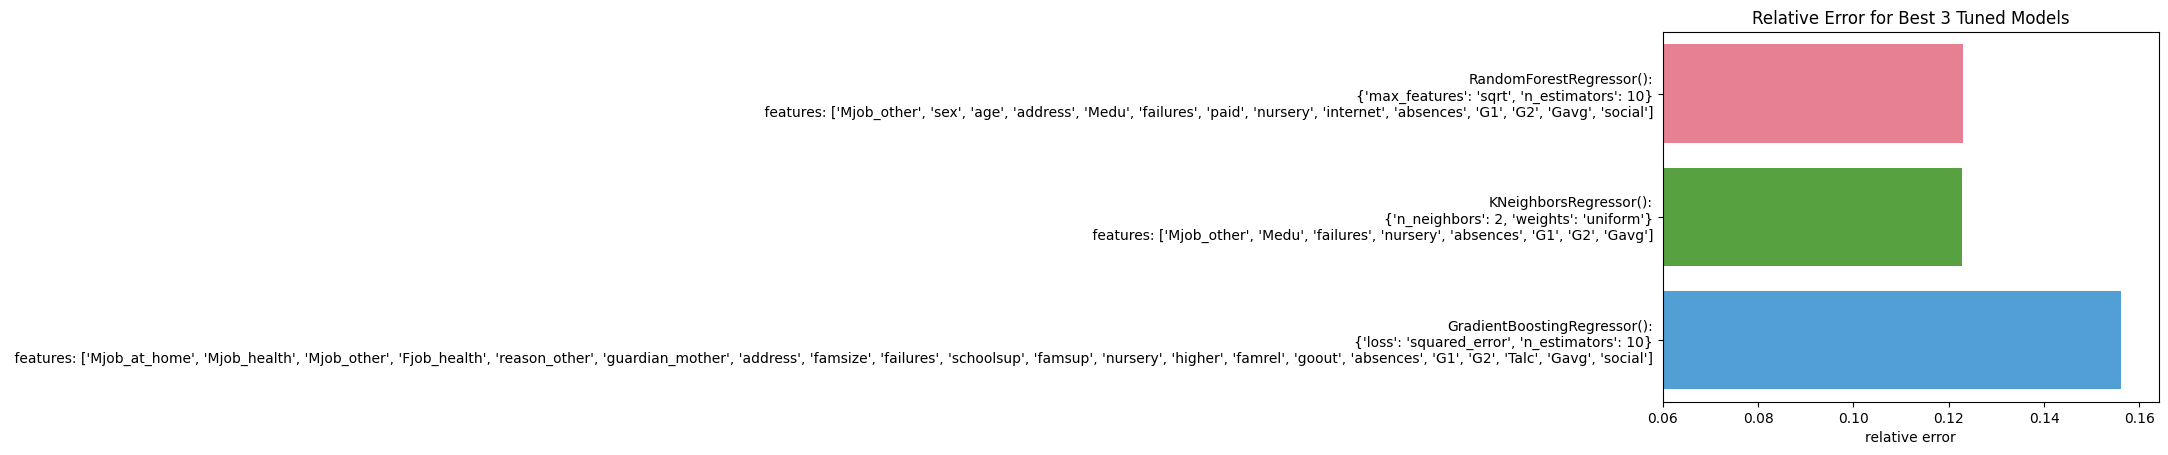

In [185]:
sns.barplot(y= tuned_stats['summary'], x = tuned_stats['relative error'], palette = sns.color_palette('husl',3))
plt.ylabel('')
plt.xlim(0.06)
plt.title("Relative Error for Best 3 Tuned Models")
plt.savefig('figures/relative_e_tuned.png', dpi = 300, bbox_inches='tight')

/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_19544/2733013714.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y= tuned_stats['summary'], x = tuned_stats['r2'], palette = sns.color_palette('husl',3))


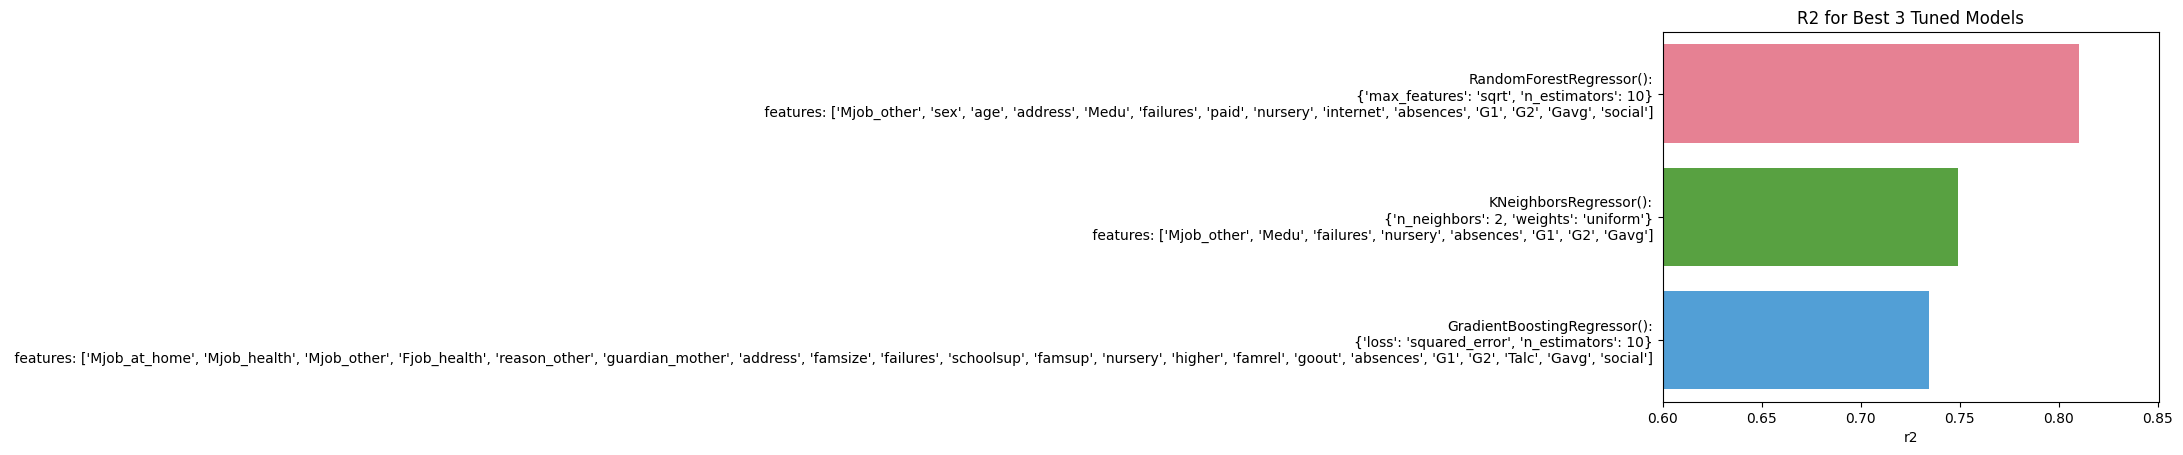

In [184]:
sns.barplot(y= tuned_stats['summary'], x = tuned_stats['r2'], palette = sns.color_palette('husl',3))
plt.ylabel('')
plt.xlim(0.6)
plt.title("R2 for Best 3 Tuned Models")
plt.savefig('figures/r2_tuned.png', dpi = 300, bbox_inches='tight')

In [114]:
tuned_stats.head(6)

,model,params,n,features,r2,mse,mae,percent_e,summary
0,RandomForestRegressor(),"{'max_features': 'sqrt', 'n_estimators': 10}",10,"[address, Medu, schoolsup, activities, higher,...",0.852718,3.133158,1.215789,0.109479,"RandomForestRegressor(), {'max_features': 'sqr..."
1,GradientBoostingRegressor(),"{'loss': 'squared_error', 'n_estimators': 10}",14,"[Mjob_at_home, address, Medu, studytime, failu...",0.729390,5.756732,1.749020,0.157495,"GradientBoostingRegressor(), {'loss': 'squared..."
2,KNeighborsRegressor(),"{'n_neighbors': 2, 'weights': 'uniform'}",8,"[address, Pstatus, failures, absences, G1, G2,...",0.769786,4.897368,1.163158,0.104739,"KNeighborsRegressor(), {'n_neighbors': 2, 'wei..."
